#!/bin/bash
#
# Copyright © 2013-2024 NVIDIA CORPORATION & AFFILIATES. ALL RIGHTS RESERVED.
#
# This software product is a proprietary product of Nvidia Corporation and its affiliates
# (the "Company") and all right, title, and interest in and to the software
# product, including all associated intellectual property rights, are and
# shall remain exclusively with the Company.
#
# This software product is governed by the End User License Agreement
# provided with the software product.
#
# author: Alex Fok
# date:   Mar 03, 2024
#

In [120]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # data processing
import csv
import tarfile
import os
import re
import argparse
#import utils
from tqdm import tqdm


# Environment setup
%pip install -r requirements.txt
np.seterr(divide = 'ignore') 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload




[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: C:\Users\afok\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# Parse raw events file and generate csv file

# Can be taken from UFM:
- `def get_events_by_ids(self, event_ids):`
- `def raw_data_csv_parser(self, event):`
- `def parse_logs_blob_into_csv(self, logs_blob_path, csv_path):`
- `def analyze(self, action, param, _start_time, _end_time, _timezone, is_async, offline_analysis_path):`
- `def extract_log_files_from_sysdump(sysdump_path, output_path):`




In [121]:
def parse_logs_blob_into_csv(logs_blob_path, csv_path):
    # Event fields indexes
    DATE = 0
    TIME = 1
    TRAP_ID = 2
    EVENT_ID = 3
    TRAP_LEVEL = 4
    TRAP_CATEGORY = 5
    TRAP_SOURCE = 7
    OBJ_TYPE = 6

    #CSV Headers
    HEADER_TIMESTAMP = 'TimeStamp'
    HEADER_TRAPID = 'TrapID'
    HEADER_EVENTID = 'EventID'
    HEADER_SEVERITY = 'Severity'
    HEADER_CATEGORY = 'Category'
    HEADER_OBJECTTYPE = 'ObjectType'
    HEADER_SOURCE = 'Source'
    HEADER_OBJECTID = 'ObjectID'
    HEADER_PAYLOAD = 'Payload'
    HEADER_DESCRIPTION = 'Description'
    HEADER_EVENTS_COUNT = 'Events Count'
    ID_REG = re.compile('\[.*\] ')
    _DEF_ID_REG = re.compile('\[.*\]:')

    file_size = os.path.getsize(logs_blob_path)
    file_pos = 0
    pbar = tqdm(total=file_size, unit="MB")
    with open(logs_blob_path, 'r') as src:
        with open(csv_path, 'w') as csv_dst:
            dst_writer = csv.writer(csv_dst)
            header = ['TimeStamp', 'TrapID', 'EventID', 'Severity', 'Category', 'ObjectType', 'Source', 'ObjectID', 'Payload']
            dst_writer.writerow(header)
            for i, event in enumerate(src):
                file_pos += len(event)
                if not i % 10:
                    pbar.update(file_pos - pbar.n)
                row = []
                splitted_eve = event.split()
                #TimeStamp
                row.append(' '.join((splitted_eve[DATE],splitted_eve[TIME])))
                #TrapID
                row.append(re.sub('[\[|\]]', '', splitted_eve[TRAP_ID]))
                #EventID
                row.append(re.sub('[\[|\]]', '', splitted_eve[EVENT_ID]))
                #Severity
                row.append(splitted_eve[TRAP_LEVEL])
                #Category
                row.append(re.sub('[\[|\]]', '', splitted_eve[TRAP_CATEGORY]))
                #Object Type
                row.append(re.sub('[\[|\]]', '', splitted_eve[OBJ_TYPE]))
                #Source
                row.append(re.sub('[\[|\]]', '', splitted_eve[TRAP_SOURCE]))
                #ID
                suffix = ' '.join(splitted_eve[TRAP_SOURCE:])
                id_match = ID_REG.match(suffix)
                if id_match is None:
                    id_match = _DEF_ID_REG.match(suffix)
                row.append(re.sub('[\[|\]|:]', '', id_match.group()))
                #Payload
                a = ' '.join(splitted_eve[TRAP_SOURCE:])[id_match.end():]
                row.append(a)
                dst_writer.writerow(row)
    pbar.close()
    return csv_path


In [122]:
# Parse raw events file and generate csv file
logs_blob_path = ".\sysdump_data\sysdump\sysdump-dsm07-0101-0912-01ufm-20230110-191826_events_in_range.log"
csv_path = ".\sysdump_data\sysdump\sysdump-dsm07-0101-0912-01ufm-20230110-191826_parsed_events.csv"
#%ls "./sysdump_data/sysdump"
csv_file = parse_logs_blob_into_csv(logs_blob_path, csv_path)


100%|█████████▉| 249437960/249438382 [01:41<00:00, 2466252.65MB/s]


In [123]:
in_file = csv_path
header = ['TimeStamp', 'TrapID', 'EventID', 'Severity', 'Category', 'ObjectType', 'Source', 'ObjectID', 'Payload']
dtypes = {
    'Device ID':object,
#    'Event ID': int64,
    'Timestamps': object
}
dtypes = {
    'Device ID':object,
#    'Event ID': int64,
    'Timestamp': object
}
#events = pd.read_csv('sysdump_data/analyzer_output_object_sysdump.csv', dtype = dtypes, parse_dates=['Timestamps'])
events = pd.read_csv(in_file, parse_dates=['TimeStamp'])
print(f'number of events: {events.shape[0]}')
print(f'attributes: {events.columns}')
print(f'attributes types:\n{events.dtypes}')

print(f'Show some data:')
events.head(5)


number of events: 1018264
attributes: Index(['TimeStamp', 'TrapID', 'EventID', 'Severity', 'Category', 'ObjectType',
       'Source', 'ObjectID', 'Payload'],
      dtype='object')
attributes types:
TimeStamp     datetime64[ns]
TrapID                 int64
EventID                int64
Severity              object
Category              object
ObjectType            object
Source                object
ObjectID              object
Payload               object
dtype: object
Show some data:


,TimeStamp,TrapID,EventID,Severity,Category,ObjectType,Source,ObjectID,Payload
0,2021-08-10 00:01:01.596,660261,110,WARNING,Hardware,IBPort,default(250),default(250) / Switch dsm07-0101-0913-16ib0 / 39,[dev_id: b8cef60300581d04]: Symbol-Error count...
1,2021-08-10 00:01:01.621,660265,110,WARNING,Hardware,IBPort,default(249),default(249) / Switch dsm07-0101-0914-12ib0 / 37,[dev_id: 043f720300c44418]: Symbol-Error count...
2,2021-08-10 00:01:31.996,660276,110,WARNING,Hardware,IBPort,default(250),default(250) / Switch dsm07-0101-0911-11ib0 / 26,[dev_id: b8cef6030054dec8]: Symbol-Error count...
3,2021-08-10 00:02:02.401,660284,110,WARNING,Hardware,IBPort,default(251),default(251) / Switch dsm07-0101-0914-08ib0 / 36,[dev_id: b8cef6030054d728]: Symbol-Error count...
4,2021-08-10 00:02:53.440,660301,392,MINOR,Hardware,Module,default(250),default(250) / Switch dsm07-0101-0912-10ib0 / ...,[dev_id: b8cef6030054da08]: Module Temperature...


# Load policy file

In [124]:
# Load policy file
col_Names=["EventID", "ShortDesc", "Abbreviation", "c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8", "c9", "c10", "c11", "SEVERITY", "c12", "c13", "c14", "ObjectType", "FormatStr", "Scope", "c15", "Description", "c16"]
policy = pd.read_csv('policy.csv', names=col_Names)
print(f'number of policies: {policy.shape[0]}')
print(f'attributes: {policy.columns}')
print(f'attributes types:\n{policy.dtypes}')

print(f'Show some data:')
policy.head(5)


number of policies: 296
attributes: Index(['EventID', 'ShortDesc', 'Abbreviation', 'c1', 'c2', 'c3', 'c4', 'c5',
       'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'SEVERITY', 'c12', 'c13', 'c14',
       'ObjectType', 'FormatStr', 'Scope', 'c15', 'Description', 'c16'],
      dtype='object')
attributes types:
EventID           int64
ShortDesc        object
Abbreviation     object
c1                int64
c2                int64
c3                int64
c4                int64
c5                int64
c6                int64
c7                int64
c8                int64
c9                int64
c10               int64
c11               int64
SEVERITY         object
c12               int64
c13               int64
c14               int64
ObjectType       object
FormatStr        object
Scope            object
c15               int64
Description      object
c16             float64
dtype: object
Show some data:


,EventID,ShortDesc,Abbreviation,c1,c2,c3,c4,c5,c6,c7,...,SEVERITY,c12,c13,c14,ObjectType,FormatStr,Scope,c15,Description,c16
0,64,GID Address In Service,SM_GID_IN_SERVICE,0,1,1,1,0,0,1,...,Info,1,300,0,Port,"GID Address In Service: prefix %(prefix)016x,g...",Fabric Notification,0,New GID is connected to the Fabric,NaN
1,65,GID Address Out of Service,SM_GID_OUT_OF_SERVICE,0,1,1,1,0,0,1,...,Warning,1,300,0,Port,GID Address Out of Service: prefix %(prefix)01...,Fabric Notification,0,Existing GID is disconnected from the Fabric,NaN
2,66,New MCast Group Created,SM_MCAST_GROUP_CREATED,0,1,1,1,0,0,1,...,Info,1,300,0,Port,"New MCast group is created: %(prefix)016x, %(p...",Fabric Notification,0,New Multicast Group is created in SM,NaN
3,67,MCast Group Deleted,SM_MCAST_GROUP_DELETED,0,1,1,1,0,0,1,...,Info,1,300,0,Port,"Mcast group is deleted: %(prefix)016x, %(pkey)08x",Fabric Notification,0,Multicast Group is removed from SM,NaN
4,110,Symbol Error,PM_SYMBOLERROR,1,1,1,1,0,0,1,...,Warning,200,300,0,Port,Symbol-Error counter rate threshold exceeded. ...,Hardware,0,Total number of minor link errors detected on ...,NaN


### Data Statistics

In [125]:
events_counts = events['EventID'].value_counts()
events_counts


328     158241
329     156219
1500    139948
65      136132
122      68089
67       51140
66       48771
392      39596
110      36288
123      30727
604      27977
112      26071
331      21525
116      18523
64       15061
917      13900
113      12578
332      11872
915       1068
393       1031
114        513
394        473
544        445
540        445
517        383
908        191
391        188
603        180
527        143
1502       133
702        114
134         82
516         62
907         56
403         20
145         19
539         11
529          5
605          5
115          5
352          5
1420         4
910          4
602          3
546          3
531          3
133          2
909          2
528          2
135          2
1503         1
1415         1
518          1
121          1
Name: EventID, dtype: int64

## Add additional attributes from policy to events
## Find top events

In [99]:
## Add additional attributes from policy to events
#events.Timestamps.value_counts()
columns = ['DeviceID', 'EventID', 'Timestamp']
events2 = events.reindex(columns=columns)
events1 = events2.loc[:,columns]
events1 = pd.merge(events, policy, on="EventID")
events_ext = events1[['DeviceID', 'EventID', 'Timestamp', 'ShortDesc']]
#events_ext['Event ID'].value_counts()

#events_ext.sort_values(by='Event ID', ascending=False).head(10)[['Device ID', 'Event ID', 'DESCRIPTION']]
#events_counts = events_ext['Event ID'].value_counts()
# Count and sort events by Event ID
#events_counts = events_ext.groupby('Event ID')['SHORT_DESC'].value_counts().sort_values(ascending=False)
events_counts = events_ext.groupby('EventID')['ShortDesc'].value_counts().sort_values(ascending=False)
#events_counts = events_counts.head(3).unstack(fill_value=0)
print(events_counts)
top_events = events_counts.head(3)
print(top_events)
top_events_list = top_events.index.get_level_values(1).tolist()
print(top_events_list)


# EventID  ShortDesc 
# 328      Link is Up                                   158241
# 329      Link is Down                                 156219
# 1500     New Cable Detected                           139948
# 65       GID Address Out of Service                   136132
# 122      Congested Bandwidth (%) Threshold Reached     68089
# 67       MCast Group Deleted                           51140
# 66       New MCast Group Created                       48771
# 392      Module Temperature Threshold Reached          39596
# 110      Symbol Error                                  36288
# 123      Port Bandwidth (%) Threshold Reached          30727
# 604      Report Succeeded                              27977
# 112      Link Downed                                   26071
# 331      Node is Down                                  21525
# 116      Port Xmit Discards                            18523
# 64       GID Address In Service                        15061
# 917      Critical Symbol BER reported                  13900
# 113      Port Receive Errors                           12578
# 332      Node is Up                                    11872
# 915      Critical BER reported                          1068
# 393      Switch Module Added                            1031
# 114      Port Receive Remote Physical Errors             513
# 394      Module status FAULT                             473
# 544      Daily Report Mail Sent Failed                   445
# 540      Daily Report Completed successfully             445
# ...
# 329      Link is Down          156219



EventID  ShortDesc                                
328      Link is Up                                   158241
329      Link is Down                                 156219
1500     New Cable Detected                           139948
65       GID Address Out of Service                   136132
122      Congested Bandwidth (%) Threshold Reached     68089
67       MCast Group Deleted                           51140
66       New MCast Group Created                       48771
392      Module Temperature Threshold Reached          39596
110      Symbol Error                                  36288
123      Port Bandwidth (%) Threshold Reached          30727
604      Report Succeeded                              27977
112      Link Downed                                   26071
331      Node is Down                                  21525
116      Port Xmit Discards                            18523
64       GID Address In Service                        15061
917      Critical Symbol BER repor

## Plot top events by timestamp

In [129]:
print(f'attributes: {events.columns}')
print(f'attributes types:\n{events.dtypes}')
ts_max = events['TimeStamp'].max()
ts_min = events['TimeStamp'].min()
print(f'ts_max: {ts_max}, ts_min: {ts_min}')

#ts = events['EventID']
#ts = events.index['Timestamp']
events['date'] = pd.to_datetime(events['TimeStamp'])
events11 = events.resample(pd.Timedelta(hours=12), on='date').sum()

attributes: Index(['TimeStamp', 'TrapID', 'EventID', 'Severity', 'Category', 'ObjectType',
       'Source', 'ObjectID', 'Payload'],
      dtype='object')
attributes types:
TimeStamp     datetime64[ns]
TrapID                 int64
EventID                int64
Severity              object
Category              object
ObjectType            object
Source                object
ObjectID              object
Payload               object
dtype: object
ts_max: 2022-10-29 14:32:14.401000, ts_min: 2021-08-10 00:01:01.596000


KeyError: 'TimeSamp'

In [114]:
## Plot top events by timestamp

# plot the results with headers for specific events
#print(f'columns: {events.columns}')
#print(f'index: {events.index}')
#events_ext_ts_idx = events.set_index('Timestamp', inplace=False)
events_ext_ts_idx = events
#events_ext_ts_idx = events_ext.set_index('Timestamp', inplace=False)
fig, ax = plt.subplots()
#top_events_list = ["Port Xmit Constraint Errors", "Link is Down", "Link is Up"]
for event in top_events_list:
#for event in [117, 328, 329]:
#    filtered_events = events_ext_ts_idx.loc[events_ext_ts_idx['Event ID'] == event]
    filtered_events = events_ext_ts_idx.loc[events_ext_ts_idx['EventID'] == event]
#    print(f'attributes: {events_328.columns}')
#    print(f'attributes types:\n{events_328.dtypes}')
#    print(events_328.loc[events_328['Event ID'] == event])
    grouped_events = filtered_events.groupby(['Timestamp', 'EventID']).size().unstack(fill_value=0)
    print(f'attributes: {grouped_events.columns}')
    print(f'attributes: {grouped_events.index}')
#    grouped_events = grouped_events.resample(pd.Timedelta(hours=48)).sum()
#    grouped_events.plot(ax=ax,style="-o") parse_dates=['TimeStamp']
#    grouped_events = grouped_events.set_index('Timestamp', inplace=False)
    
    #grouped_events['date'] = pd.to_datetime(grouped_events.index)
    #grouped_events = grouped_events.set_index('date')
    grouped_events = grouped_events.resample(pd.Timedelta(hours=12)).sum()
    grouped_events.plot(ax=ax)
    plt.xlabel("Hours of Day")
    plt.ylabel("Events Counter")
plt.legend()
plt.show()


KeyError: "None of ['Timestamp'] are in the columns"

# TODO: find noisy devices from top events

In [191]:
device_counts = events_ext.groupby('Device ID')['SHORT_DESC'].value_counts().sort_values(ascending=False)
#events_counts = events_counts.head(3).unstack(fill_value=0)
print(device_counts)
top_devices = device_counts.head(3)
print(top_devices)
top_devices_list = top_devices.index.get_level_values(0).tolist()
print(top_devices_list)

Device ID                              SHORT_DESC                          
DSM082031002003:dsm08-0102-0310-03ib0  Link is Down                            590
                                       Link is Up                              590
dsm08-0102-0310-03ib0 / 4              Port Xmit Constraint Errors             114
dsm08-0102-0310-03ib0 / 1              Port Xmit Constraint Errors             114
dsm08-0102-0310-03ib0 / 8              Port Xmit Constraint Errors             114
                                                                              ... 
dsm08-0102-0310-03ib0 / 26             Unhealthy IB Port                         1
dsm08-0102-0310-03ib0 / 27             Unhealthy IB Port                         1
dsm08-0102-0310-03ib0 / 38             Symbol Error                              1
dsm08-0102-0310-03ib0 / 32             Port Bandwidth (%) Threshold Reached      1
dsm08-0102-0310-03ib0 / 35             Symbol Error                              1
Name: SHORT

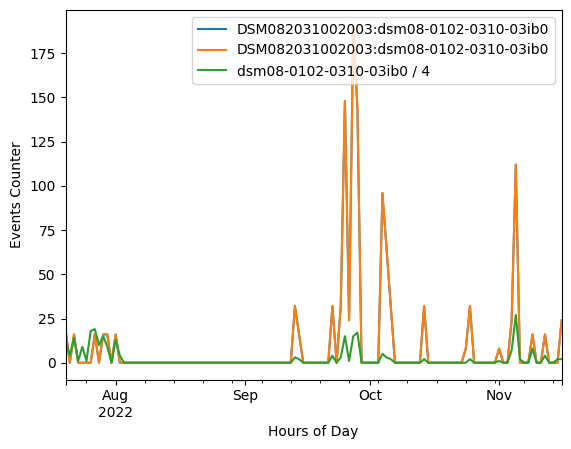

In [194]:
## Plot top devices by timestamp

# plot the results with headers for specific events
events_ext_ts_idx = events_ext.set_index('Timestamps', inplace=False)
fig, ax = plt.subplots()
#top_events_list = ["Port Xmit Constraint Errors", "Link is Down", "Link is Up"]
for device in top_devices_list:
#for event in [117, 328, 329]:
#    filtered_events = events_ext_ts_idx.loc[events_ext_ts_idx['Event ID'] == event]
    filtered_events = events_ext_ts_idx.loc[events_ext_ts_idx['Device ID'] == device]
#    print(f'attributes: {events_328.columns}')
#    print(f'attributes types:\n{events_328.dtypes}')
#    print(events_328.loc[events_328['Event ID'] == event])

#    grouped_events = filtered_events.groupby(['Timestamps', 'SHORT_DESC', 'Device ID']).size().unstack(fill_value=0)
    grouped_events = filtered_events.groupby(['Timestamps', 'Device ID']).size().unstack(fill_value=0)
#    print(f'attributes: {grouped_events.columns}')
#    grouped_events = grouped_events.resample(pd.Timedelta(hours=48)).sum()
#    grouped_events.plot(ax=ax,style="-o")
    grouped_events = grouped_events.resample(pd.Timedelta(hours=24)).sum()
    grouped_events.plot(ax=ax)
    plt.xlabel("Hours of Day")
    plt.ylabel("Events Counter")
plt.legend()
plt.show()


### Top 10

In [ ]:
## Groupby timestamp
#events_byevents = exents_ext.groupby('Timestamps')['Event ID'].sum()
# 329, 328
#events_byevents = events_ext.groupby(events_ext['Timestamps'].dt.strftime('%Y-%m-%d'))['Event ID'].size().unstack(fill_value=0)
#df_resampled = events.resample('D').sum()
#daily_quality.plot(kind='bar')
#print(events_byevents.head(5))
#events_byevents.plot.hist(bins=10)
#plt.show()
#events_byevents.plot()

# Create DF with specific events
events_328 = events_ext.loc[events_ext['Event ID'] == 328]
events_329 = events_ext.loc[events_ext['Event ID'] == 329]
grouped = events_328.groupby(['Timestamps', 'Event ID']).size().unstack(fill_value=0)
#events_328.plot()
## Groupby timestamp
#events_byevents = exents_ext.groupby('Timestamps')['Event ID'].sum()
# 329, 328
#events_byevents = events_ext.groupby(events_ext['Timestamps'].dt.strftime('%Y-%m-%d'))['Event ID'].size().unstack(fill_value=0)
#df_resampled = events.resample('D').sum()
#daily_quality.plot(kind='bar')
#print(events_byevents.head(5))
#events_byevents.plot.hist(bins=10)
#plt.show()
#events_byevents.plot()

# Create DF with specific events
events_328 = events_ext.loc[events_ext['Event ID'] == 328]
events_329 = events_ext.loc[events_ext['Event ID'] == 329]
print(f'attributes: {events_328.columns}')
print(f'attributes types:\n{events_328.dtypes}')

#grouped = events_328.groupby(['Timestamps', 'Event ID']).size().unstack(fill_value=0)
#events_328.plot()
#grouped = events_ext.groupby(['Timestamps', 'Event ID']).size().unstack(fill_value=0)

# plot the results with headers for specific events
events_ext_ts_idx = events_ext.set_index('Timestamps', inplace=False)
#events_328 = events_ext_ts_idx.loc[events_ext_ts_idx['Event ID'] == 328]
#print(f'attributes: {events_ext_ts_idx.columns}')
#print(f'attributes types:\n{events_ext_ts_idx.dtypes}')
fig, ax = plt.subplots()
#for event in ["Link is Down", "Link is Up"]:
for event in [328, 329]:
    events_328 = events_ext_ts_idx.loc[events_ext_ts_idx['Event ID'] == event]
    print(f'attributes: {events_328.columns}')
    print(f'attributes types:\n{events_328.dtypes}')
#    print(events_328.loc[events_328['Event ID'] == event])
    grouped = events_328.groupby(['Timestamps', 'Event ID']).size().unstack(fill_value=0)
#    grouped = grouped.resample(pd.Timedelta(hours=2)).mean()
    grouped = grouped.resample(pd.Timedelta(days=1)).max()
    print(grouped)
    grouped.plot(ax=ax)
#    events_328.loc[events_328['Event ID'] == event].plot(ax=ax, x = events_328.index[-1], label=str(event))
#    ax.text(events_328.index[-1], events_328.loc[events_328['Event ID'] == event], str(event), ha='left', va='center')
#    ax.text(events_328.index[-1], events_328[event].iloc[-1], event, ha='left', va='center')
plt.legend()
plt.show()







#print(events_328)

# set the index to the timestamp column
#events_ext.set_index('Timestamps', inplace=True)
events_ext_ts_idx = events_ext.set_index('Timestamps', inplace=False)

# group the dataframe by 15 minute intervals and calculate the mean
print(f'attributes: {events_ext_ts_idx.columns}')
print(f'attributes types:\n{events_ext_ts_idx.dtypes}')
events_byevents = events_ext_ts_idx.resample(pd.Timedelta(hours=2)).mean()
print(f'attributes: {events_byevents.columns}')
print(f'attributes types:\n{events_byevents.dtypes}')
# group the dataframe by timestamp and event
#grouped = events_ext.groupby(['Timestamps', 'SHORT_DESC']).size().unstack(fill_value=0)

#grouped = events_byevents.groupby(['Timestamps', 'SHORT_DESC']).size().unstack(fill_value=0)
grouped = events_byevents.groupby(['Timestamps', 'Event ID']).size().unstack(fill_value=0)

#print(f'attributes: {grouped.columns}')
#print(f'attributes types:\n{grouped.dtypes}')
#print(grouped)
# plot the results with headers for specific events
fig, ax = plt.subplots()
#for event in ["Link is Down", "Link is Up"]:
for event in ['328', '329']:
    grouped[event].plot(ax=ax, label=event)
    ax.text(grouped.index[-1], grouped[event].iloc[-1], event, ha='left', va='center')
plt.legend()
plt.show()

In [5]:
top_10 = events.sort_values(by='Event ID', ascending=False).head(10)
top_10

,Device ID,Event ID,Timestamps
1272,dsm08-0102-0310-03ib0 / 5,702,2022-09-25 05:27:50.577
4020,dsm08-0102-0310-03ib0 / 28,702,2022-10-10 22:07:49.973
246,dsm08-0102-0310-03ib0 / 1,702,2022-11-05 03:59:47.514
504,dsm08-0102-0310-03ib0 / 2,702,2022-11-05 04:00:15.854
505,dsm08-0102-0310-03ib0 / 2,702,2022-09-28 02:38:11.455
506,dsm08-0102-0310-03ib0 / 2,702,2022-09-25 17:40:16.021
4012,dsm08-0102-0310-03ib0 / 27,702,2022-10-10 22:07:49.972
761,dsm08-0102-0310-03ib0 / 3,702,2022-11-05 04:00:15.855
762,dsm08-0102-0310-03ib0 / 3,702,2022-09-25 05:27:40.915
1522,dsm08-0102-0310-03ib0 / 6,702,2022-11-05 04:00:15.861


In [6]:
events['Device ID'].value_counts()

DSM082031002003:dsm08-0102-0310-03ib0          1180
dsm08-0102-0310-03ib0 / 2                       260
dsm08-0102-0310-03ib0 / 1                       257
dsm08-0102-0310-03ib0 / 4                       256
dsm08-0102-0310-03ib0 / 8                       256
dsm08-0102-0310-03ib0 / 5                       255
dsm08-0102-0310-03ib0 / 3                       254
dsm08-0102-0310-03ib0 / 6                       251
dsm08-0102-0310-03ib0 / 7                       249
MT4123:dsm08-0102-0310-03ib0                    208
dsm08-0102-0310-03ib1:dsm08-0102-0310-03ib0      66
dsm08-0102-0310-07ib1:dsm08-0102-0310-03ib0      66
dsm08-0102-0310-05ib1:dsm08-0102-0310-03ib0      66
dsm08-0102-0310-01ib1:dsm08-0102-0310-03ib0      66
dsm08-0102-0310-08ib1:dsm08-0102-0310-03ib0      48
dsm08-0102-0310-04ib1:dsm08-0102-0310-03ib0      44
dsm08-0102-0310-06ib1:dsm08-0102-0310-03ib0      44
dsm08-0102-0310-02ib1:dsm08-0102-0310-03ib0      44
dsm08-0102-0310-04ufm:dsm08-0102-0310-03ib0      22
dsm08-0102-0

Timestamps
2022-07-20 00:22:21.553    112
2022-07-20 00:22:21.554    112
2022-07-20 00:22:21.555    112
2022-07-20 00:22:21.556    112
2022-07-20 00:22:21.560    112
Name: Event ID, dtype: int64


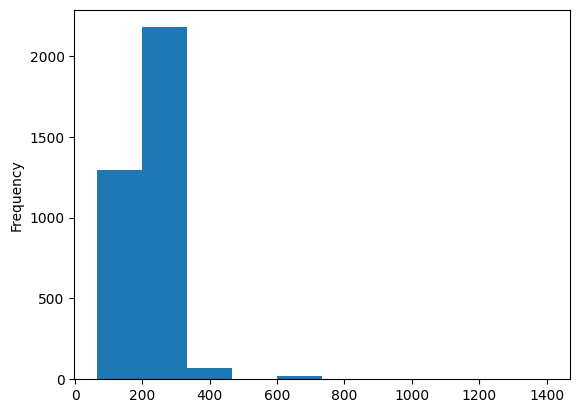

In [7]:
#n_by_event = events.groupby('Device ID')["Event ID"].count().sort_values()
#n_by_event.head(10).plot(kind='bar') 
#events['alt_date'] = events.to_datetime(df['Timestamps'], unit='s')
events_byevents = events.groupby('Timestamps')['Event ID'].sum()
#df_resampled = events.resample('D').sum()
#daily_quality.plot(kind='bar')
print(events_byevents.head(5))
events_byevents.plot.hist(bins=10)

plt.show()

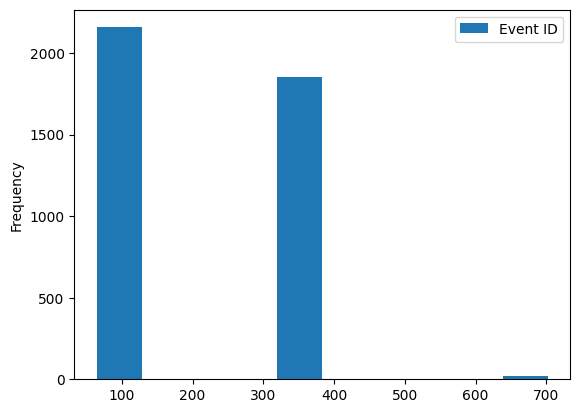

In [ ]:
events.plot(x="Timestamps", y=["Event ID"], kind="hist")
#events.plot(x="Timestamps", y=["Event ID", "Device ID"], kind="hist")
plt.show()